In [48]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
sns.set()

In [3]:
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
import numpy as np

In [4]:
#load reviews
reviews=pd.read_csv("reviews_clean.csv")
reviews=reviews.dropna()

#load recipes
recipes=pd.read_csv("recipes_clean.csv")

#Convert ingredient and ingredient strings into ingredient lists
recipes["Ingredients_clean"]=recipes["Ingredients_clean"].apply(eval)
recipes["Ingredients_clean"]=recipes["Ingredients_clean"].apply(lambda x : list(set(x)))
recipes["Instructions"]=recipes["Instructions"].apply(lambda x : simple_preprocess(" ".join(eval(x))))


In [5]:
#train_test_split
from sklearn.model_selection import train_test_split

#### How are ratings from 1 to 5 distributed ?

In [6]:
#Number of reviews for each recipe
review_count=reviews.groupby("Recipe_ID").size()

#mean rating for each recipes
ratings_mean=reviews.groupby("Recipe_ID")["Rating"].mean()

#Number of ratings for each star-category
ratings_count=pd.DataFrame(reviews.groupby("Rating").size(),columns=["Count"]).reset_index()

#Number of reviews for each user
user_review_count=reviews.groupby("Reviewer_ID").size()

#Mean rating for each user
user_mean_rating=reviews.groupby("Reviewer_ID")["Rating"].mean()

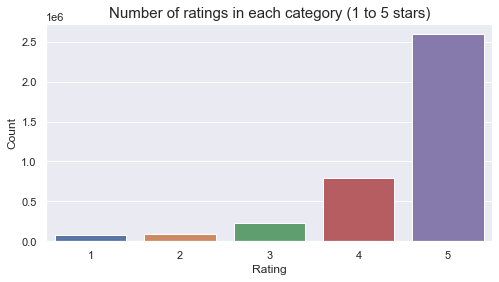

In [7]:
fig,ax=plt.subplots(figsize=(8,4))
sns.barplot(ratings_count["Rating"],ratings_count["Count"]);
ax.set_title("Number of ratings in each category (1 to 5 stars)",fontsize=(15));

#### Distribution of the number of reviews per user

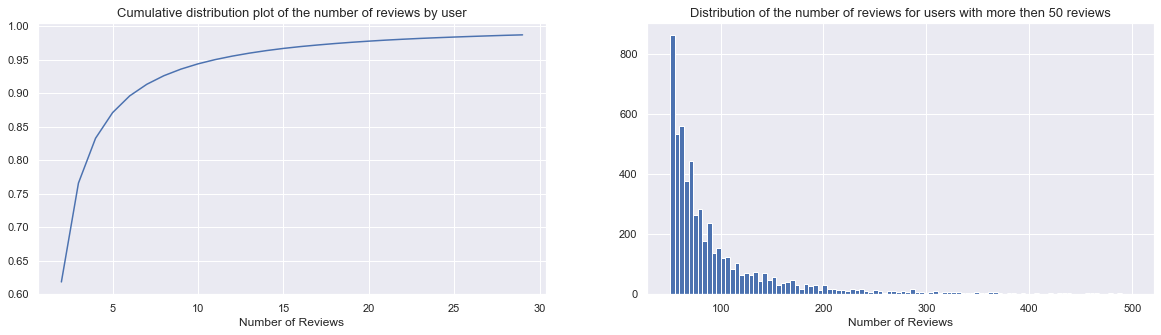

In [8]:
fig,axes=plt.subplots(1,2,figsize=(20,5))

axes[0].plot([i for i in range(2,30)],[len(user_review_count[user_review_count<i])/len(user_review_count)  for i in range(2,30)]);
axes[0].set_title("Cumulative distribution plot of the number of reviews by user",fontsize=13);
axes[0].set_xlabel("Number of Reviews",fontsize=12);

axes[1].hist(user_review_count[(user_review_count>50) & (user_review_count<500)],bins=100);
axes[1].set_title("Distribution of the number of reviews for users with more then 50 reviews",fontsize=13);
axes[1].set_xlabel("Number of Reviews",fontsize=12);


#### Do somes user tend to be more severe than others ?

In [9]:
#Creating a reviews table containing number 1,2,3,4,5 ratings for each user
users=pd.DataFrame(reviews["Reviewer_ID"].unique(),columns=["Reviewer_ID"])
users[1]=1

ratings=pd.DataFrame(reviews["Rating"].unique(),columns=["Rating"])
ratings[1]=1

reviews_table=pd.merge(users,ratings,on=1).drop(1,axis=1)
reviews_table=pd.merge(reviews_table,reviews.groupby(["Reviewer_ID","Rating"]).size().reset_index(),on=["Reviewer_ID","Rating"],how="left").fillna(0)
reviews_table=reviews_table.rename(columns={0 : "Counts"})

In [10]:
reviews_table=reviews_table[reviews_table["Reviewer_ID"].isin(user_review_count[user_review_count>20].index)]

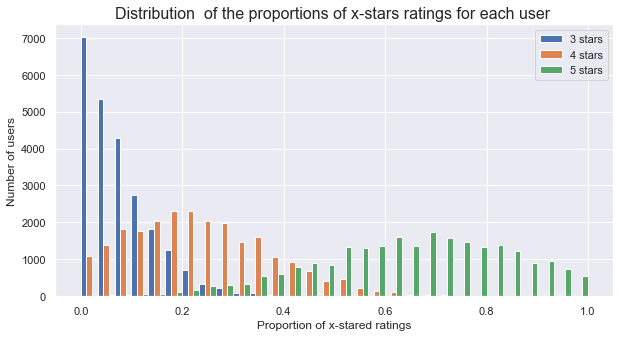

In [11]:
fig,ax=plt.subplots(1,1,figsize=(10,5))
rating_dist=[(reviews_table[reviews_table["Rating"]==i].groupby("Reviewer_ID")["Counts"].sum()/reviews_table.groupby("Reviewer_ID")["Counts"].sum()) for i in range(3,6)]
ax.hist(rating_dist, label=["3 stars","4 stars","5 stars"],stacked=False,bins=30,rwidth=500);
ax.legend();
ax.set_xlabel("Proportion of x-stared ratings",fontsize=12);
ax.set_ylabel("Number of users",fontsize=12);
ax.set_title("Distribution  of the proportions of x-stars ratings for each user ",fontsize=16);

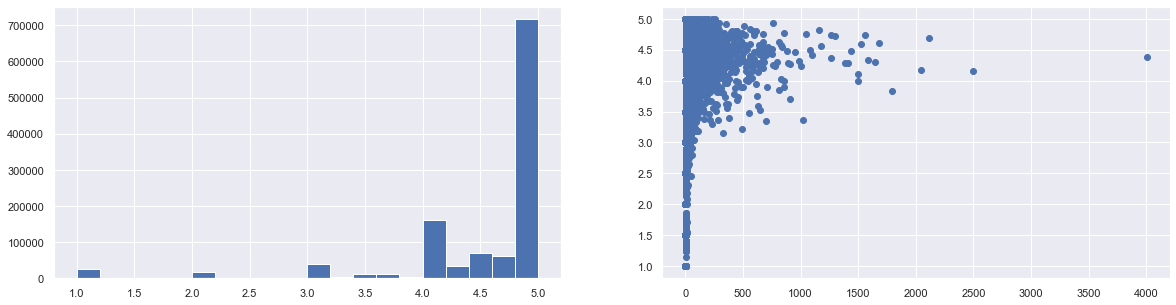

In [12]:
fig,axes=plt.subplots(1,2,figsize=(20,5))
axes[0].hist(user_mean_rating,bins=20);
axes[1].scatter(user_review_count,user_mean_rating);

In [13]:
review_count_cut=review_count[review_count.between(review_count.quantile(0),review_count.quantile(0.8))]
ratings_cut=ratings_mean[review_count.between(review_count.quantile(0),review_count.quantile(0.8))]

#### Is the average rating of a recipe correlated to its number of reviews ?

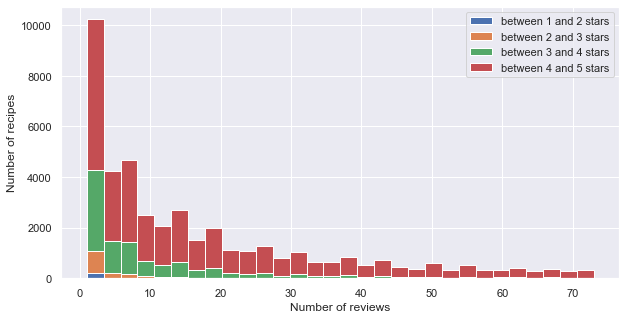

In [14]:
fig,ax=plt.subplots(1,1,figsize=(10,5))
classes=[review_count_cut[ratings_cut.between(i,i+1)] for i in np.linspace(1,4,4)]
ax.hist(classes, label=["between 1 and 2 stars","between 2 and 3 stars","between 3 and 4 stars","between 4 and 5 stars"],stacked=True,bins=30);
#sns.scatterplot(review_count,ratings,ax=ax[1]);
ax.legend();
ax.set_xlabel("Number of reviews", fontsize=12);
ax.set_ylabel("Number of recipes",fontsize=12);

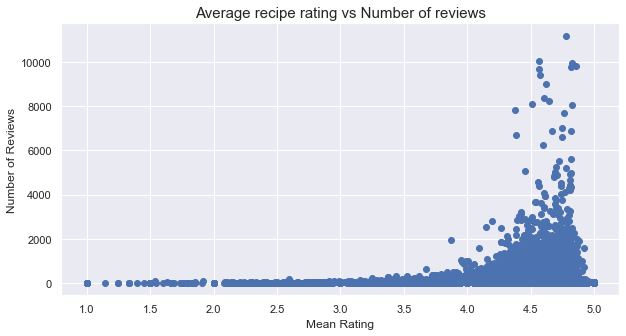

In [15]:
fig,ax=plt.subplots(1,1,figsize=(10,5))
plt.scatter(ratings_mean,review_count);
ax.set_xlabel("Mean Rating", fontsize=12);
ax.set_ylabel("Number of Reviews",fontsize=12);
ax.set_title("Average recipe rating vs Number of reviews",fontsize=15);

#### Distribution of ingredients

In [16]:
from gensim.corpora import Dictionary

#Define Dictionary of Ingredients
dictionary = Dictionary(recipes["Ingredients_clean"])

#Fiter Ingredients that appear in at least 10 recipes
dictionary.filter_extremes(no_below=10,no_above=1)

In [17]:
#Define Ingredient matrix : one-hot encode which ingredient appears in which recipe
ingredient_matrix=gensim.matutils.corpus2dense([dictionary.doc2bow(recipe) for recipe in recipes["Ingredients_clean"]], num_terms=len(dictionary))
ingredient_matrix=ingredient_matrix.T
ingredient_matrix=pd.DataFrame(ingredient_matrix,index=recipes["Recipe_ID"],columns=list(dictionary.token2id.keys()))

In [18]:
ingredient_matrix.head()

,baking powder,baking soda,basil,buttermilk,cheese,corn,cornmeal,egg,flour,onion,...,coconut water,sriracha,sriracha sauce,vanilla protein powder,gluten free,ritz cracker,sriracha hot,sriracha hot sauce,coconut sugar,diamond salt
Recipe_ID,,,,,,,,,,,,,,,,,,,,,
6664,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6663,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6665,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6666,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6668,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
ingredient_count=ingredient_matrix.replace(0,np.nan).sum()

In [20]:
ingredient_count.sort_values(ascending=False)[:10]

salt               16789.0
white sugar        11231.0
flour              10442.0
egg                10173.0
water               9286.0
butter              8535.0
milk                7754.0
black pepper        7460.0
olive oil           7036.0
vanilla extract     6053.0
dtype: float32

#### Are some ingredients tastier than others  ?

In [21]:
#Define ingredient rating : average rating of all recipes in which the ingredient appears
ingredient_count=ingredient_matrix.replace(0,np.nan).sum()
ingredient_ratings=ingredient_matrix.replace(0,np.nan).multiply(reviews.groupby("Recipe_ID")["Rating"].mean(),axis=0).mean()                                                                                                    

In [22]:
len(dictionary)

1489

In [23]:
ingredient_ratings.sort_values(ascending=False)[:10]

anaheim chile pepper          4.763165
ritz cracker                  4.756381
pork back                     4.739394
baguette                      4.719352
ice cream                     4.713101
dry italian salad dressing    4.712435
duck                          4.696793
strawberry glaze              4.696481
cremini mushroom              4.672118
pink                          4.667532
dtype: float64

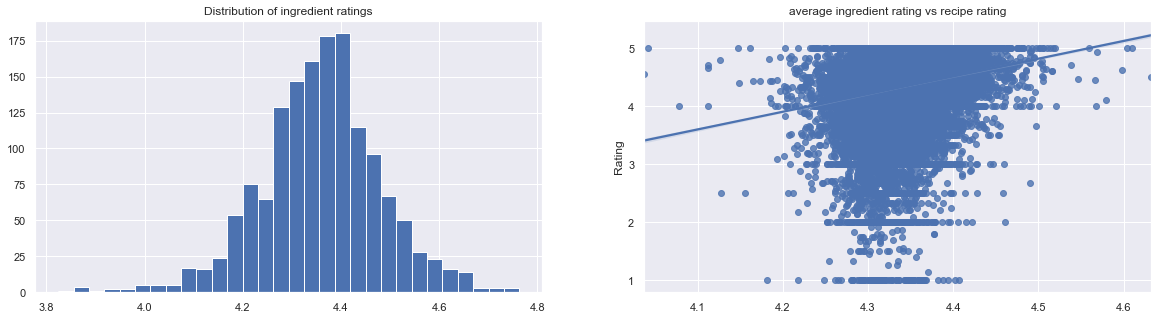

In [24]:
fig,ax=plt.subplots(1,2,figsize=(20,5));
ax[0].hist(ingredient_ratings,bins=30);
sns.regplot((ingredient_matrix*ingredient_ratings).replace(0,np.nan).mean(axis=1),ratings_mean,ax=ax[1]);

ax[0].set_title("Distribution of ingredient ratings");
ax[1].set_title("average ingredient rating vs recipe rating");

In [25]:
significant_ingredients=ingredient_ratings[~ingredient_ratings.between(0,ingredient_ratings.mean()+ingredient_ratings.std())]

In [26]:
significant_ingredients.sort_values(ascending=False)

anaheim chile pepper    4.763165
ritz cracker            4.756381
pork back               4.739394
baguette                4.719352
ice cream               4.713101
                          ...   
puff pastry             4.483278
popcorn                 4.483231
feta cheese             4.482324
skirt steak             4.482309
tortilla                4.481861
Length: 204, dtype: float64

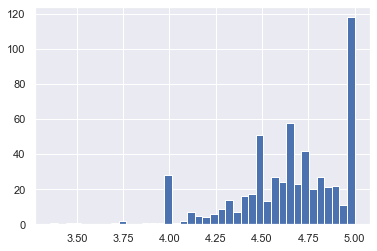

In [27]:
g=reviews[reviews["Recipe_ID"].isin(ratings_mean[ingredient_matrix[significant_ingredients.index].sum(axis=1)>1].index)]
plt.hist(g.groupby(["Recipe_ID"])["Rating"].mean(),bins=40);

#### Ingredient Segmentation based on their coocurrence in recipes

In [30]:
recipes["ingredients_grouped"]=[[ingredient.split()[-1] for ingredient in ingredients] for ingredients in recipes["Ingredients_clean"]]

In [35]:
from gensim.corpora import Dictionary

#Define Dictionary of Ingredients
dictionary = Dictionary(recipes["ingredients_grouped"])

#Fiter Ingredients that appear in at least 10 recipes
dictionary.filter_extremes(no_below=20,no_above=1)

In [36]:
len(dictionary)

495

In [37]:
#Define Ingredient matrix : one-hot encode which ingredient appears in which recipe
from gensim.matutils import corpus2csc
ingredient_matrix_sparse=gensim.matutils.corpus2csc([dictionary.doc2bow(recipe) for recipe in recipes["Ingredients_clean"]], num_terms=len(dictionary))

#Define coocurrence matrix
import sklearn
term_term_matrix=np.dot(ingredient_matrix_sparse, ingredient_matrix_sparse.T)

#Cosine similarity
X=pd.DataFrame(sklearn.metrics.pairwise.cosine_similarity(term_term_matrix))
X.columns=dictionary.token2id.keys()
X.index=dictionary.token2id.keys()

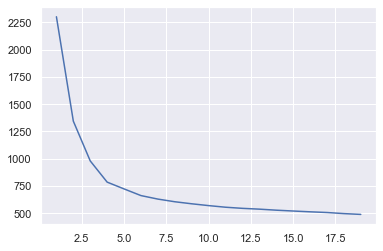

In [38]:
#roughly evelatuate number of clusters with elbow method
from sklearn.cluster import KMeans
inertia=[]
for i in range(1,20) : 
    kmeans = KMeans(n_clusters=i, random_state=0).fit(X)
    inertia.append(kmeans.inertia_)

plt.plot([i for i in range(1,20)],inertia)

In [39]:
# apply kmeans on chosen number of clusters
n_labels=10
kmeans = KMeans(n_clusters=n_labels, random_state=0).fit(X)

In [40]:
#Apply pca to X in order to plot clusters
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(X)
to_plot=pca.transform(X)

In [41]:
to_plot=pd.DataFrame(to_plot)
to_plot["label"]=kmeans.labels_
to_plot.columns=["X","Y","label"]

Index(['bell', 'seasoning', 'mayonnaise', 'sauce', 'jalapeno', 'sesame',
       'sausage', 'olive', 'rice', 'broth', 'bean', 'paste', 'mango', 'black',
       'soup', 'red', 'rom', 'spaghetti', 'chili', 'radish', 'pasta', 'noodle',
       'cucumber', 'horseradish', 'leg', 'avocado', 'cilantro', 'herb',
       'kidney', 'caper', 'baby', 'shiitake', 'anchovy', 'soy', 'mint',
       'tahini', 'chorizo', 'linguine', 'pickle', 'pine', 'bok', 'plum',
       'wood', 'fish', 'serrano', 'chickpea', 'habanero', 'meatball',
       'eggplant', 'kielbasa', 'curry', 'brisket', 'sirloin', 'fennel',
       'hominy', 'navy', 'flank', 'poblano', 'collard', 'nori', 'hamburger',
       'bamboo', 'edamame', 'worcestershire', 'kaiser', 'chipotle',
       'scallion'],
      dtype='object')

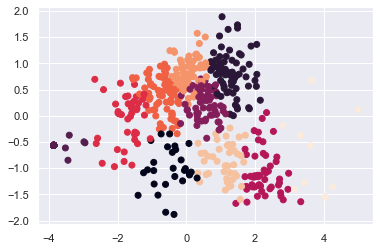

In [50]:
#plot clusters
plt.scatter(to_plot["X"],to_plot["Y"],c=to_plot["label"]);

X["label"]=kmeans.labels_

X[X["label"]==7].index

In [51]:
X.groupby("label").size()

label
0    28
1    72
2    50
3    62
4    51
5    42
6    72
7    67
8    42
9     9
dtype: int64

In [52]:
ingredients=pd.Series(list(dictionary.token2id.keys()))
ingredients_last=pd.DataFrame(ingredients.str.split().str[-1],columns=["ingredient"])
groups=pd.DataFrame(ingredients_last.drop_duplicates().values,columns=["ingredient"]).reset_index()
groups=pd.merge(ingredients_last,groups,on="ingredient",how="left")["index"]

In [53]:
ingredients_grouped=pd.DataFrame(ingredients, columns=["ingredient"])
ingredients_grouped["group"]=groups

#### Recipe segmentation based on ingredient segmentation

In [55]:
recipe_ingredients_grouped=pd.DataFrame(index=recipes.index)[:5000]

In [77]:
recipe_ingredients_grouped

,0,1,2,3,4,5,6,7,8,9,...,4990,4991,4992,4993,4994,4995,4996,4997,4998,4999
0,1.000000,0.597614,0.675303,0.868037,0.616581,0.613572,0.842750,0.723573,0.707107,0.806226,...,0.753119,0.559017,0.614919,0.653197,0.701253,0.387298,0.842750,0.912871,0.737865,0.699252
1,0.597614,1.000000,0.350931,0.288195,0.491304,0.366679,0.564076,0.419314,0.338062,0.222375,...,0.709208,0.534522,0.267261,0.878310,0.545777,0.308607,0.644658,0.545545,0.503953,0.691669
2,0.675303,0.350931,1.000000,0.849548,0.931034,0.990830,0.950169,0.927047,0.996546,0.837611,...,0.589662,0.328266,0.131306,0.239732,0.325601,0.000000,0.673036,0.750479,0.433289,0.198228
3,0.868037,0.288195,0.849548,1.000000,0.707957,0.776713,0.877846,0.845910,0.886593,0.986945,...,0.572293,0.323498,0.377415,0.275625,0.408955,0.124515,0.650256,0.836428,0.559161,0.348837
4,0.616581,0.491304,0.931034,0.707957,1.000000,0.945792,0.910579,0.875545,0.913500,0.691939,...,0.616465,0.393919,0.196960,0.335624,0.344754,0.151620,0.712627,0.750479,0.433289,0.226546
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,0.387298,0.308607,0.000000,0.124515,0.151620,0.000000,0.174078,0.169842,0.000000,0.000000,...,0.648181,0.721688,0.866025,0.632456,0.800044,1.000000,0.609272,0.353553,0.680414,0.747087
4996,0.842750,0.644658,0.673036,0.650256,0.712627,0.672214,0.818182,0.709575,0.667424,0.543557,...,0.923186,0.753778,0.678401,0.770675,0.879599,0.609272,1.000000,0.861640,0.781736,0.780307
4997,0.912871,0.545545,0.750479,0.836428,0.750479,0.700140,0.861640,0.760609,0.774597,0.792594,...,0.708333,0.510310,0.612372,0.521749,0.595491,0.353553,0.861640,1.000000,0.673575,0.528271
4998,0.737865,0.503953,0.433289,0.559161,0.433289,0.404226,0.568535,0.600925,0.447214,0.457604,...,0.817913,0.942809,0.824958,0.688530,0.790756,0.680414,0.781736,0.673575,1.000000,0.762493


In [56]:
for i in range(n_labels) :
    recipe_ingredients_grouped[i]=[len([X["label"][ingredient] for ingredient in ingredients if (ingredient in dictionary.token2id.keys() and X["label"][ingredient]==i)]) for ingredients in recipes["Ingredients_grouped"][:5000]]

In [57]:
#Cosine similarity
recipe_ingredients_grouped=pd.DataFrame(sklearn.metrics.pairwise.cosine_similarity(recipe_ingredients_grouped))
#X.columns=dictionary.token2id.keys()
#X.index=dictionary.token2id.keys()

In [58]:
#Apply pca to X in order to plot clusters
from sklearn.decomposition import PCA
pca = PCA(n_components=5)
pca.fit(recipe_ingredients_grouped)
recipe_matrix_reduced=pca.transform(recipe_ingredients_grouped)

In [59]:
pca.explained_variance_ratio_

array([0.77863465, 0.11193294, 0.05016006, 0.02356429, 0.01557052])

In [60]:
kmeans = KMeans(n_clusters=20, random_state=0).fit(recipe_matrix_reduced)
recipe_matrix_reduced=pd.DataFrame(recipe_matrix_reduced)
recipe_matrix_reduced["label"]=kmeans.labels_

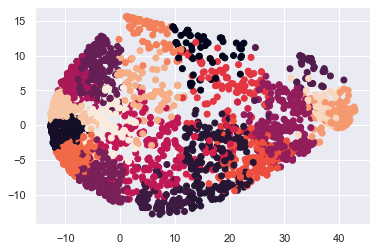

In [61]:
#plot clusters
plt.scatter(recipe_matrix_reduced.iloc[:,0],recipe_matrix_reduced.iloc[:,1],c=recipe_matrix_reduced["label"]);

In [74]:
temp=recipe_matrix_reduced[:5000].copy()

temp["label"][:5000]=kmeans.labels_

#### Content-based recommender system (using ingredients only)

In [37]:
def index_to_id(index_list) :
    id_list=[]
    for index in index_list :
        id_list.append(recipes["Recipe_ID"].iloc[index])
    return id_list

import ipyplot

In [79]:
recipes.iloc[800]["Recipe_name"]

'Cheesecake Supreme'

In [38]:
def plot_recipes(recipe_list) :
    images=[]
    labels=[]
    for recipe_ID in recipe_list :
        images.append("Images/{}.jpg".format(recipe_ID))
        labels.append(recipes[recipes["Recipe_ID"]==recipe_ID]["Recipe_name"].iloc[0])
        #labels.append(recipes.iloc[recipe_ID]["Recipe_name"])
          
    images=np.array(images)
    labels=np.array(labels)
    
    ipyplot.plot_images(images, labels=labels,max_images=100, img_width=150);
    
    return(images,labels)
    

In [81]:
bow_corpus = [dictionary.doc2bow(ingredients) for ingredients in recipes["Ingredients_clean"]]

In [82]:
from gensim.models import TfidfModel
model=TfidfModel(bow_corpus)

In [83]:
from gensim.similarities import MatrixSimilarity
index = MatrixSimilarity(model[bow_corpus], num_features=len(dictionary))

In [84]:
plot_recipes(index_to_id(index[bow_corpus[100]].argsort()[-20:][::-1]));

In [104]:
plot_recipes(index_to_id(index[bow_corpus[2100]].argsort()[-20:][::-1]));

#### Collaborative filtering recommender system (using ingredients only)

In [14]:
#keep only recipes with more than 10 reviews
mask=reviews.groupby("Recipe_ID").size()[reviews.groupby("Recipe_ID").size()>60].index
reviews=reviews[reviews["Recipe_ID"].isin(mask)]
recipes=recipes[recipes["Recipe_ID"].isin(mask)]

In [15]:
#Keep only users with more than 8 reviews
mask=reviews.groupby("Reviewer_ID").size()[reviews.groupby("Reviewer_ID").size()>15].index
reviews=reviews[reviews["Reviewer_ID"].isin(mask)]
recipes=recipes[recipes["Recipe_ID"].isin(reviews["Recipe_ID"].unique())]

In [18]:
from sklearn.model_selection import train_test_split
Recipe_ids_train,Recipe_ids_test=train_test_split(recipes["Recipe_ID"],test_size=0.25,random_state=42)

In [19]:
reviews_train=reviews[reviews["Recipe_ID"].isin(Recipe_ids_train)]
reviews_test=reviews[reviews["Recipe_ID"].isin(Recipe_ids_test)]

In [20]:
users_reviews_pivot_matrix = reviews_train.pivot(index='Reviewer_ID', columns='Recipe_ID', values='Rating').fillna(0)

In [21]:
users_reviews_pivot_matrix.head()

Recipe_ID,6666,6683,6687,6697,6698,6700,6706,6713,6717,6725,...,233983,234534,234803,235151,235874,235997,236609,239047,239993,240784
Reviewer_ID,,,,,,,,,,,,,,,,,,,,,
32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
39,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
138,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
240,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
338,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0


In [22]:
from sklearn.metrics.pairwise import cosine_similarity
user_similarity_matrix=cosine_similarity(users_reviews_pivot_matrix)

In [24]:
def index_to_recipe_id(index_list) :
    id_list=[]
    for index in index_list :
        id_list.append(recipes["Recipe_ID"].iloc[index])
    return id_list

import ipyplot

In [26]:
# from scipy.sparse import csr_matrix
from  scipy.sparse import csr_matrix
users_reviews_pivot_sparse_matrix = csr_matrix(users_reviews_pivot_matrix)

In [27]:
from scipy.sparse.linalg import svds
#The number of factors to factor the user-item matrix.
NUMBER_OF_FACTORS_MF = 15
#Performs matrix factorization of the original user item matrix
#U, sigma, Vt = svds(users_items_pivot_matrix, k = NUMBER_OF_FACTORS_MF)

U, sigma, Vt = svds(users_reviews_pivot_sparse_matrix, k = NUMBER_OF_FACTORS_MF)

In [49]:
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) 

In [32]:
#Converting the reconstructed matrix back to a Pandas dataframe
cf_preds_df = pd.DataFrame(all_user_predicted_ratings, columns = users_reviews_pivot_matrix.columns, index=users_reviews_pivot_matrix.index).transpose()

In [33]:
cf_preds_df[240].sort_values(ascending=False).index[:10]

Int64Index([15004, 16066, 26317, 10687, 25037, 11967, 8694, 14469, 26692,
            8350],
           dtype='int64', name='Recipe_ID')

In [34]:
cf_preds_df

Reviewer_ID,32,39,138,240,338,403,521,638,650,1224,...,21975917,22079061,22083120,22106825,22164581,22232683,22318942,22386021,22404317,22450440
Recipe_ID,,,,,,,,,,,,,,,,,,,,,
6666,0.030874,0.048198,-0.000303,0.023290,0.069449,0.015997,0.035174,0.013224,0.025928,-0.009599,...,0.001247,0.002280,0.038917,0.008048,0.034159,0.005170,-0.008871,0.018737,-0.008201,0.005542
6683,0.050337,0.061453,-0.010104,0.096804,0.092561,0.041480,0.075550,0.034267,-0.010016,-0.062154,...,-0.022882,0.005447,0.119654,0.020041,0.036278,-0.000405,-0.012626,0.076023,-0.027222,-0.034055
6687,0.068561,0.155658,0.051684,0.181733,0.157529,0.019391,0.147026,0.046830,0.061456,0.090577,...,0.066571,0.003576,0.140565,0.043962,0.027198,0.000669,0.041219,0.021462,0.039904,0.020936
6697,0.049768,0.067985,0.006146,0.059887,0.083714,-0.009160,0.058178,-0.000799,0.040347,0.039543,...,0.046556,0.006957,0.056992,0.030513,0.006832,0.006373,0.008696,0.008965,0.022785,0.009502
6698,1.365399,1.035111,0.141126,0.115633,0.841520,0.158176,0.386167,-0.068833,0.282848,0.252799,...,0.019647,0.011984,-0.335304,0.730987,0.716871,0.127050,0.050149,0.050930,0.035996,0.273420
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235997,0.000670,0.052816,-0.007080,0.012267,0.074386,0.010662,-0.002325,0.007140,0.027923,-0.000278,...,0.015737,0.014507,-0.018027,0.011013,0.029586,0.014176,0.013742,0.025856,0.009573,-0.000748
236609,-0.029366,0.050298,-0.026594,0.019662,0.269081,-0.028776,-0.043140,-0.022839,0.053653,-0.024963,...,0.032213,0.047019,-0.029389,-0.008876,0.078795,0.041408,0.009781,0.039029,0.063573,0.037671
239047,-0.015574,0.056324,-0.009096,0.008158,0.126460,0.016486,-0.015818,0.010607,0.034357,-0.007541,...,0.016304,0.022510,-0.034216,0.006047,0.055253,0.020968,0.016240,0.035303,0.018563,0.009082


In [63]:
plot_recipes(cf_preds_df[521].sort_values(ascending=False).index[:20]);

In [60]:
plot_recipes(cf_preds_df[22079061].sort_values(ascending=False).index[:20]);